# Building EO training/validation/testing datasets with the Sentinelhub API

#### The following modules/Libraries will be needed

In [4]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig, WmsRequest, WcsRequest, DataSource, MimeType
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import rasterio
import numpy as np
import datetime

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

Generate a configuration:
This is done using the ID.
This is so that sentinelhub knows you are authorised to use their service, and which parts of the service you want to use.

In [ ]:
INSTANCE_ID = '1dfaf55b-29b6-4669-9d4d-a27bbd511784'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

print(config)

Define a region and a random test date 

In [ ]:
class SentinelData:
    """
    Retreiveing Sentinel data from Sentinel Hub
    initialise class with coordinates list, resolution, bounding box coordinates, years and month ranges
    make a wcs request for data between November-April
    """
    def __init__(self, coords_list, years, day_month_to, day_month_from):
        self.coords_list = coords_list
        self.resolution = '10m'
        self.area_coords = BBox(bbox=self.coords_list, crs=CRS.WGS84)
        self.year_range = years # make a set of years to iterate over 
        self.day_month_to = day_month_to
        self.day_month_from = day_month_from
        
        
        
    def retrieve_data(self):
        """ 
        Create a bounding box and assign CRS. 
        Create a wcs data request from Sentinel for Sentinel-2 data. 
        Define max clouds as 20%
        """
        for year in self.year_range:
            time_from = "{}-{}".format(year, self.day_month_from)
            print("time_from", time_from)
            time_to = "{}-{}".format(year + 1,  self.day_month_to)
            print("time_to", time_to)
            # make the request for the desired date range 
            wcs_true_color_request = WcsRequest (
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords,
                time= (time_from, time_to),
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0 # You can define the maximum ammount of cloud coverage you want to allow. 
            )
            print("WCS: ", wcs_true_color_request)
    
            available_dates_list = wcs_true_color_request.get_dates()
            print("avail dates list: ", available_dates_list)
            yield from available_dates_list
            
    
    def get_available_data(self):
        """
        Use get_data() function from Sentinel to retrieve available data for the dates.
        """
        available_dates_list = self.retrieve_data()
        for date in available_dates_list:
            print("date", date)
            
            wcs_true_color_request = WcsRequest(
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords, 
                time= date,
                resx='10m', # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0,# You can define the maximum ammount of cloud coverage you want to allow.
                data_folder='/Users/emilybirch/Documents/UCL_Dissertation' 
            )
            
            basemap = wcs_true_color_request.get_data()[0] 
            #print("BASEMAP", basemap)
           # print(type(basemap))
           
            call_wms = self.bands_req(basemap, date)
            # save_data=True
            print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
            print(f'Single element in the list is of type {type(basemap[-1])} and has shape {basemap[-1].shape}')
           
            # yield from basemap


            

    # put def bands_req here         
    def bands_req(self, basemap, date):
       # for basemap in self.get_available_wms_data():
        basemap = np.array(basemap)
        wms_bands_request = WmsRequest(
            data_collection=DataCollection.SENTINEL2_L1C,
            layer='BANDS-S2-L2A', # We are using the 'BANDS-S2-L2A layer now'
            bbox=self.area_coords, 
            width=basemap.shape[1], # 10m resolution dims are sourced from the basemap. 
            height=basemap.shape[0],
            time=(date),
            image_format=MimeType.TIFF, 
            maxcc=0,
            #resx='10m',
           # resy = '10',
            config=config
        )        
        
        bands = wms_bands_request.get_data()[-1]
       # print(type(bands))
        bands = np.array(bands)
        bands = bands.astype('float32') 
        #print(bands.shape)
       

        plot_all_channels = self.plot_channels(bands, basemap)
     

                  
        
        
    
    def plot_data(self):   
        """
        Plot the satellite data to check there is suitable cloud cover 
        and that the image is not cropped.
        """
        basemap = self.get_available_data()
        i = 0
        for sat_img in basemap:
            i += 1
            print("i", i)
           # print("SAT IMG", sat_img[0])
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
            plt.imshow(sat_img)
            plt.axis('off')
            plt.savefig('ala_sat_4_{}.png'.format(i),
                        bbox_inches='tight',
                        dpi=300)
            plt.show()
          
    
    # put plot channels here 
          
    def plot_channels(self, bands, basemap):
        """
        Plot out each channel to see how they look
        """
        #bands = self.get_available_wms_data()
        
        #basemap = self.get_available_wms_data()    
        b01 = bands[:,:,0] # Coastal Aerosol
        b02 = bands[:,:,1] # Blue
        b03 = bands[:,:,2] # Green
        b04 = bands[:,:,3] # Red
        b05 = bands[:,:,4] # Vegetation Red Edge 
        b06 = bands[:,:,5] # Vegetation Red Edge
        b07 = bands[:,:,6] # Vegetation Red Edge
        b08 = bands[:,:,7] # NIR
        b08a = bands[:,:,8] # Vegetation Red Edge
        b09 = bands[:,:,9] # Water Vapour
        b11 = bands[:,:,10] # SWIR
        b12 = bands[:,:,11] # SWIR
        
        i = 0
        for channel in bands:
            i += 1
            print("i", i)
            fig, ax = plt.subplots(2, 6, figsize=(15,6))
            ax[0, 0].imshow(b01, cmap='cubehelix')
            ax[0, 0].set_title('Coastal Aerosol')
            ax[0, 0].axis('off')
            ax[0, 1].imshow(b02, cmap='cubehelix')
            ax[0, 1].set_title('Blue')
            ax[0, 1].axis('off')
            ax[0, 2].imshow(b03, cmap='cubehelix')
            ax[0, 2].set_title('Green')
            ax[0, 2].axis('off')
            ax[0, 3].imshow(b04, cmap='cubehelix')
            ax[0, 3].set_title('Red')
            ax[0, 3].axis('off')
            ax[0, 4].imshow(b05, cmap='cubehelix')
            ax[0, 4].set_title('Vegetation Red Edge ')
            ax[0, 4].axis('off')
            ax[0, 5].imshow(b07, cmap='cubehelix')
            ax[0, 5].set_title('Vegetation Red Edge ')
            ax[0, 5].axis('off')
            ax[1, 0].imshow(b08, cmap='cubehelix')
            ax[1, 0].set_title('Vegetation Red Edge ')
            ax[1, 0].axis('off')
            ax[1, 1].imshow(b08a, cmap='cubehelix')
            ax[1, 1].set_title('NIR')
            ax[1, 1].axis('off')
            ax[1, 2].imshow(b09, cmap='cubehelix')
            ax[1, 2].set_title('Vegetation Red Edge')
            ax[1, 2].axis('off')
            ax[1, 3].imshow(b11, cmap='cubehelix')
            ax[1, 3].set_title('SWIR')
            ax[1, 3].axis('off')
            ax[1, 4].imshow(b12, cmap='cubehelix')
            ax[1, 4].set_title('SWIR')
            ax[1, 4].axis('off')
            ax[1, 5].imshow(basemap, cmap='cubehelix')
            ax[1, 5].set_title('True Colour composite')
            ax[1, 5].axis('off')
           # plt.savefig('bands_can_1_{}.png'.format(i),
           #             bbox_inches='tight',
           #             dpi=300)
            #plt.show()
            call_plot_ndsi = self.plot_index(b03, b11, b04, basemap)
                        


    def plot_index(self, b03, b11,b04, basemap):
        """
        Plot ndsi using certain bands
        """

        # calc Normalised difference snow index 
        # calc normalised difference vegetation index
        NDSI = (b03 - b11)/(b03 + b11) 
        NDVI = (b04 – b03) / (b04 + b03)
        fig, ax = plt.subplots(1, 3, figsize=(15,10))
        # ax.imshow(basemap)
        ax[0].imshow(basemap)
        ax[0].set_title('True Colour Composite')

        ax[1].imshow(NDSI, cmap='Blues')
        ax[1].set_title('NDSI')
        
        ax[2].imshow(NDVI, cmap='Blues')
        ax[2].set_title('NDVI')

        # plt.savefig('NDSI.png', dpi=600)
        plt.show()


        
        
        

 # define the years and month ranges for data. Nov-April so there is snow cover.
# Sentinel 2 data is only available from 2015 onwards


# FORESTED:

# FRANCE BBOX 1. 0%CC
#s2, w2 = 46.00263, 6.68625
#n2, e2 = 46.21018, 7.00556


# FRANCE BBOX 2. 0%CC
#s2, w2 = 44.5032, 6.26995
#n2, e2 = 44.71395, 6.57683

# FRANCE BBOX 3. 0%CC. in Vosges mountains. 
#s2, w2 = 47.89925, 6.75874
#n2, e2 = 48.0968, 7.0709
    



# NEW ZEALAND 0% CC. BBOX1. FORESTED. gets 3 3/4 pics 
#s2, w2 = -44.64093, 168.67527
#n2,e2 = -44.42578, 168.99039


# NZ BBOX 2 FORESTED. 3 pics  
#s2,w2 = -44.46215, 169.15172
#n2,e2 = -44.26874, 169.4559


# NZ BBOX 3. 3 pics 
#s2,w2 = -45.57742, 167.32814
#n2,e2 = -45.37906, 167.63988


# NZ bbox 4. 
#s2,w2 = -44.21029, 168.7185
#n2, e2 = -43.99234, 169.00415
    

##################################    
    
# NON-FORESTED:  
# Norway. scandy mountains. works but forest?
#s2, w2 = 61.19427, 6.71053
#n2, e2 = 61.39842, 7.14765
  

# BBOX 2 
# s2, w2 = 62.11413, 11.91172
#n2, e2 = 62.31454, 12.35366


# BBOX 3. nr namsos
#s2, w2 = 64.5321, 11.68324
#n2, e2 = 64.72623, 12.17067





    
# Argentina. bbox 1. 
#s2, w2 = -36.1615, -70.60757
#n2, e2 = -36.35363, -70.87261
    

# Argentina BBOX2
#s2, w2 = -36.90052, -71.07906
#n2, e2 = -36.7103, -70.80853
    
   
 # Argentina BBOX3
#s2, w2 = -48.25276, -72.33129
#n2, e2 = -48.05762, -72.0168
       
  




 # Alaska bbox1 3 pics
#s2, w2 = 60.58666, -144.4895
#n2, e2 = 60.78174, -144.04753
    
    
    
# alaska bbox 2 2 pics
#s2, w2 = 60.54723, -145.6761
#n2, e2 = 60.74312, -145.24079
    

    
# alaska bbox 3. 3 pics
#s2, w2 = 60.86118, -146.57959
#n2, e2 = 61.05052, -146.14288


# alaska bbox 4. 3 pics 
#s2, w2 = 61.10963, -146.62525
#n2, e2 = 61.30145, -146.18168
    

    
    
    
    
    

# canada 0%CC. BBOX1. CANADIAN ROCKIES
s2, w2 = 50.82675, -116.08768
n2, e2 = 51.02583, -115.73474       

# CANADA BBOX2 0%CC. VANCOUVER. takes a long time to plot (90 plots)
#s2, w2 = 49.60259, -123.27264
#n2, e2 = 49.80043, -122.94511
    

# canada BBOX3. nr vancouver 
#s2, w2 = 49.98434, -124.25091
#n2, e2 = 50.19579, -123.90758
       
    
    
    
  

 
coords_canada = [w2, s2, e2, n2]

canada_years = {2014, 2015, 2016, 2017, 2018, 2019, 2020}

# define the years and month ranges for data. Nov-April
canada_day_month_to = "01-01"
canada_day_month_from = "01-01"



canada_data = SentinelData(coords_canada, canada_years, canada_day_month_to, canada_day_month_from)
# plot_data_1 = canada_data.plot_data()





#plot_canada_data = canada_data.bands_req()
# plot the individual channels for Canada wms/ web req data
plot_canada_wms = canada_data.get_available_data()
print("PLOT", plot_canada_wms)




In [62]:
# convert bbox coords into projected system to crop to
import os
import pyproj
from pyproj import Proj, transform

os.environ['PROJ_NETWORK'] = 'OFF'


def coord_conv(x1, y1, in_proj, out_proj):
    proj = pyproj.Transformer.from_crs(in_proj, out_proj)
    x2, y2 = proj.transform(x1, y1)
    print((x1, y1))
    print((x2, y2))
    return x2,y2


 
# 1. Canada:   #"epsg:4326", "epsg:3978"
#can_DEM_bbox1_ulc = coord_conv(51.02521, -116.09311, 4326, 3978)
#can_DEM_bbox1_lrc = coord_conv(50.82872, -115.73064, 4326, 3978)
# box2
#can_DEM_bbox2_ulc = coord_conv(49.7991, -123.27756,4326, 3978)
#can_DEM_bbox2_lrc = coord_conv(49.60459, -122.94316,4326, 3978)
# box3
#can_bbox3_ulc = coord_conv(50.19571, -124.25775,4326, 3978)
#can_bbox3_lrc = coord_conv(49.98687, -123.90537,4326, 3978)



# 2. France 
# bbox 1 
#Fr_bbox1_ulc = coord_conv(46.20907, 6.68394, 4326, 23030)
#Fr_bbox1_lrc = coord_conv(46.00317, 7.009, 4326, 23030)
# box2
#Fr_bbox1_ulc = coord_conv(44.71102, 6.27264,4326, 23030)
#Fr_bbox1_lrc = coord_conv(44.51403, 6.57913,4326, 23030)
# box3
#Fr_bbox1_ulc = coord_conv(48.09807, 6.75178,4326, 23030)
#Fr_bbox1_lrc = coord_conv(47.90479, 7.07567, 4326, 23030)


# Alaska
#Al_bbox1_uly = coord_conv(60.78013, -144.48842,4326, 3338)
#Al_bbox1_lrc = coord_conv(60.58568, -144.03959, 4326, 3338)

#Al_bbox2_uly = coord_conv(60.74539, -145.68114, 4326, 3338)
#Al_bbox2_lrc = coord_conv(60.54485, -145.24568, 4326, 3338)

#Al_bbox3_uly = coord_conv(61.04986, -146.59057, 4326, 3338)
#Al_bbox3_lrc = coord_conv(60.86339, -146.12749, 4326, 3338)

#Al_bbox4_uly = coord_conv(61.30673, -146.61838, 4326, 3338) 
#Al_bbox4_lrc = coord_conv(61.11029, -146.17618, 4326, 3338)


# Argentina
#Ar_bbox1_uly = coord_conv(-36.1567, -70.87755,4326, 5343)
#Ar_bbox1_lrc = coord_conv(-36.35381, -70.59671, 4326, 5343)

#Ar_bbox2_uly = coord_conv(-36.70684, -71.0794, 4326, 5343)
#Ar_bbox2_lrc = coord_conv(-36.89707, -70.81168, 4326, 5343)

#Ar_bbox3_uly = coord_conv(-48.05909, -72.3347, 4326, 5343)
#Ar_bbox3_lrc = coord_conv(-48.24508, -72.00512, 4326, 5343)


# Norway. ETRS89 / UTM is the projected CRS for Norway
Nor_bbox1_uly = coord_conv(61.39974, 6.71094,4326, 5130)
Ar_bbox1_lrc = coord_conv(61.19466, 7.15113, 4326, 5130)

Nor_bbox2_uly = coord_conv(62.31192, 11.90014, 4326, 5130)
Ar_bbox2_lrc = coord_conv(62.12052, 12.37392, 4326, 5130)

Nor_bbox3_uly = coord_conv(64.72578, 11.67157, 4326, 5130)
Nor_bbox3_lrc = coord_conv(64.53323, 12.179, 4326, 5130)




#####################
#can_list = []
# [51.02521, -116.09311,(49.7991, -123.27756), (50.19571, -124.25775)]
#x = [51.02521.....
# y = ...
#x.append
#y.append
#for coord in can_list:
#    in_proj = 4326
#    out_proj = 3978
#    x1, y1 = ulc.split(',')
#    coord_conv(x1,y1,in_proj,out_proj)


(61.39974, 6.71094)
(1611541.2847414473, -1150463.0893291135)
(61.19466, 7.15113)
(1581199.9787365836, -1136330.787145058)
(62.31192, 11.90014)
(1619389.5743942696, -854804.3331045215)
(62.12052, 12.37392)
(1591676.3046402216, -836971.2418011383)
(64.72578, 11.67157)
(1882899.119273985, -786917.6157957469)
(64.53323, 12.179)
(1855046.293116921, -769771.7641124884)


In [ ]:
#NZ
-44.42977, 168.66256
-44.63339, 168.99731

-44.26552, 169.14185
-44.45747, 169.46413

-45.37762, 167.32743
-45.58001, 167.63521

-44.00659, 168.70122
-44.19769, 169.022

EPSG:27200
    
    


    

# Norway
61.39974, 6.71094
61.19466, 7.15113

62.31192, 11.90014
62.12052, 12.37392

64.72578, 11.67157
64.53323, 12.179

EPSG:5776

If you just wanted to download a true colour composite, you could use WcsRequest()

If you want to access the full Sentinel-2 product (with all channels) you can use wms request. 

We can  then use band 2 and band 11 (SWIR and Blue) to create a normalised difference snow index (NDSI) and the normalised difference water index

In [ ]:
# mMove and rename the single .tif tiles which do not need merging
# France bbox 2. only 1 tile, so move to final DEMs folder and rename
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX2/tifs/ALPSMLC30_N044E006_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedFrDEM2.tif')

# Alaska: only 1 tif per. bbox2 and bbox4
import shutil
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX2/tifs/ALPSMLC30_N060W145_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM2.tif')
shutil.move('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX4/tifs/ALPSMLC30_N061W146_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedAlDEM4.tif')

# Argentina
import shutil
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX1/tifs/ALPSMLC30_S036W070_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM1.tif')
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX2/tifs/ALPSMLC30_S036W071_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM2.tif') 
shutil.move("/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Argentina/BOX3/tifs/ALPSMLC30_S048W072_DSM.tif", '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics/mergedArgDEM3.tif') 
    

In [37]:
# Process DEM geomorphology pics 
# merge DEM tiles, reproject to projected crs with m units, resample to 10x10m pixel size, crop to bbox
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst


# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

# can_list = [can_bbox1_path, can_bbox2_path, can_bbox3_path]
# i = 0
#for f in can_list:
    # i += 1
    # glob.glob(f)
    # cmd = "gdal_merge.py -o 'mergedCanDEM1_{}.tif'.format(i)"
    # subprocess.call(cmd.split()+f)

# CANADA. make a list of DEM files to merge. get all with .tif extension
can_bbox1_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX1/tifs/*.tif"
can_bbox2_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
can_bbox3_path = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/*.tif"
# retrieve files with this path name and extension
CanDEMList_1 = glob.glob(can_bbox1_path)
CanDEMList_2 = glob.glob(can_bbox2_path)
CanDEMList_3 = glob.glob(can_bbox3_path)
print(CanDEMList_3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedCanDEM1.tif"
subprocess.call(cmd.split()+CanDEMList_1)
# Canada bbox2 merge
cmd = "gdal_merge.py -o mergedCanDEM2.tif"
subprocess.call(cmd.split()+CanDEMList_2)
# Canada bbox3 merge
cmd = "gdal_merge.py -o mergedCanDEM3.tif"
subprocess.call(cmd.split()+CanDEMList_3)



# France. Set path to DEM tif files
fr_bbox1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BBOX1/tifs/*.tif"
fr_bbox3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/France/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
fr_list1 = glob.glob(fr_bbox1)
fr_list3 = glob.glob(fr_bbox3)

# merge the DEM tiles. bbox1
cmd = "gdal_merge.py -o mergedFrDEM1.tif"
subprocess.call(cmd.split()+fr_list1)
# Fr bbox3 merge
cmd = "gdal_merge.py -o mergedFrDEM3.tif"
subprocess.call(cmd.split()+fr_list3)



# Alaska. Set path to DEM tif files
alask_path1 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BBOX1/tifs/*.tif"
alask_path3 = "/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Alaska/BOX3/tifs/*.tif"
#retrieve files with this path name and extension
al_DEM_list1 = glob.glob(alask_path1)
al_DEM_list3 = glob.glob(alask_path3)

# call subprocess gdal merge to merge the DEM tiles
cmd = "gdal_merge.py -o mergedAlDEM1.tif"
subprocess.call(cmd.split()+al_DEM_list1)
# bbox3 merge
cmd = "gdal_merge.py -o mergedAlDEM3.tif"
subprocess.call(cmd.split()+al_DEM_list3)



# reproject coordinate system into UTM to use metres as units 
def reproj(out_file, in_file, dstSRS):
    gdal.Warp(out_file, in_file, dstSRS = crs)

# zip over lists?
# reproj for Canada: into EPSG:3978
canada_reproj_list = ['mergedCanDEM1.tif', 'mergedCanDEM2.tif', 'mergedCanDEM3.tif']
i = 0
# for in_file in zip_longest(canada_reproj_list, fr_reproj_list,al_reproj_list,... )
for in_file in canada_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojCanDEM_{}.tif'.format(i)
    crs = 'EPSG:3978'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
# France: into EPSG:23030 ED50 / UTM zone 30N
fr_reproj_list =  ['mergedFrDEM1.tif', 'mergedFrDEM2.tif', 'mergedFrDEM3.tif']
i = 0
for in_file in fr_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojFrDEM_{}.tif'.format(i)
    crs = 'EPSG:23030'
    call = reproj(out_file, in_file, crs)
    print(call)
 
 
# reproj for Alaska: into EPSG:3338
al_reproj_list = ['mergedAlDEM1.tif', 'mergedAlDEM2.tif', 'mergedAlDEM3.tif', 'mergedAlDEM4.tif']
i = 0
for in_file in al_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojAlDEM_{}.tif'.format(i)
    crs = 'EPSG:3338'
    call = reproj(out_file, in_file, crs)
    print(call)
    
# reproj for Argentina: into EPSG:5343
Arg_reproj_list = ['mergedArgDEM1.tif', 'mergedArgDEM2.tif', 'mergedArgDEM3.tif']
i = 0

for in_file in Arg_reproj_list:
    i += 1
    print("I:", i)
    out_file = 'reprojArgDEM_{}.tif'.format(i)
    crs = 'EPSG:5343'
    call = reproj(out_file, in_file, crs)
    print(call)
    
    
    

# Resample to 10x10m pixel size to match Sentinel images
def resample(out_file, in_file):
    gdal.Warp(out_file, in_file, xRes = 10, yRes = 10, resampleAlg = "bilinear")
    print("HI")
        

# list the files to resample and process then in a loop 
resamp_files_list = ['reprojCanDEM_1.tif', 'reprojCanDEM_2.tif', 'reprojCanDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Can_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
            

# France: resample
resamp_list = ['reprojFrDEM_1.tif', 'reprojFrDEM_2.tif', 'reprojFrDEM_3.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Fr_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)

    
# Alaska resample. 
# list of files to resample
resamp_list = ['reprojAlDEM_1.tif', 'reprojalDEM_2.tif', 'reprojAlDEM_3.tif', 'reprojAlDEM_4.tif']    
i = 0
for in_file in resamp_list:
    i += 1
    print("i", i)
    out_file = "resamp_Al_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)



# list the files to resample and process then in a loop 
resamp_files_list = ['reprojArgDEM_1.tif', 'reprojArgDEM_2.tif', 'reprojArgDEM_3.tif']    
i = 0
for in_file in resamp_files_list:
    i += 1
    print("i", i)
    out_file = "resamp_Arg_DEM_{}.tif".format(i)
    print("OUTfile", out_file)
    resample(out_file, in_file)
    
    
    
    
    
# Crop .tif to boudning box coords
def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
  

 
# Canada: crop .tif to boudning box coords
can1crop = crop('cropCanDEM_1.tif','resamp_Can_DEM_1.tif', -1442222.5901271082, 465767.00799028383, -1425280.668026976, 437053.54995778797) 
can2crop = crop('cropCanDEM_2.tif','resamp_Can_DEM_2.tif', -1963467.662479708, 532524.2456295489, -1950948.5651828928, 502730.9493941085)  
can3crop = crop('cropCanDEM_3.tif','resamp_Can_DEM_3.tif',-2007237.3331321548, 602651.3553773408, -1994916.2627411576, 570806.9080293514) 
       
# France: crop .tif to boudning box coords
Fr1crop = crop('cropFrDEM_1.tif','resamp_Can_DEM_1.tif',1246969.3962645088, 5163267.284300569,1274934.6912586447, 5143545.166937985) 
Fr2crop = crop('cropFrDEM_2.tif','resamp_Can_DEM_2.tif',1234624.7084396454, 4993062.539814649, 1261497.750934254, 4974014.1117675835)  
Fr3crop = crop('cropFrDEM_3.tif','resamp_Can_DEM_3.tif', 1225777.8855382334, 5373591.730970369,1252683.6911129407, 5355278.076760378) 

# Alaska: Crop .tif to boudning box coords
Al1crop = crop('cropAlDEM_1.tif','resamp_Al_DEM_1.tif', 514481.90383768355, 1236449.1310469457, 541830.6619147946, 1218503.1192803124) 
Al2crop = crop('cropAlDEM_2.tif','resamp_Al_DEM_2.tif', 450815.2605629388, 1223929.9128310417, 477228.41344957944, 1204727.699233261)  
Al3crop = crop('cropAlDEM_3.tif','resamp_Al_DEM_3.tif', 397957.2487422569, 1251934.8385985517,425182.4670500502, 1234086.2585198171) 
Al4crop = crop('cropAlDEM_4.tif','resamp_Al_DEM_4.tif',393282.9896072386, 1280321.0557472059,419319.2191957479, 1261199.193909528) 
  

# close datasets to read properly to disk
#ds = dsReproj = dsResamp = dsClip = None


['/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W122_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N050W123_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W122_DSM.tif', '/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Canada/BBOX2/tifs/ALPSMLC30_N049W124_DSM.tif']
I: 1
None
I: 2
None
I: 3
None
i 1
OUTfile resamp_Can_DEM_1.tif
HI
i 2
OUTfile resamp_Can_DEM_2.tif
HI
i 3
OUTfile resamp_Can_DEM_3.tif
HI
I: 1
None
I: 2
None
I: 3
None
i 1
OUTfile resamp_Fr_DEM_1.tif
HI
i 2
OUTfile resamp_Fr_DEM_2.tif
HI
i 3
OUTfile resamp_Fr_DEM_3.tif
HI


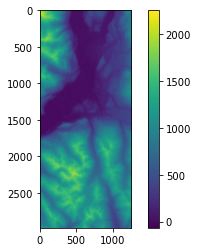

In [14]:
# plot to check DEM is reprojected, resampled and cropped to bbox
final_DEM = gdal.Open("cropDEM_2.tif")
array = final_DEM.ReadAsArray()
plt.imshow(array)
plt.colorbar()

In [59]:
# Argentina
import os 
from osgeo import gdal
import glob
import subprocess
from gdal import gdalconst


# set directory to location of all final DEM pics 
os.chdir('/Users/emilybirch/Documents/UCL_Dissertation/Data_collection/DEM/Directory_for_DEM/Final_DEM_pics')
os.getcwd()

def crop(out_file, source_file, ulx, uly, lrx, lry):
    gdal.Translate(out_file, source_file,
                  projWin = [ulx, uly, lrx, lry])
    
  


 
# FIX THESE- CANT CROP BC NOT IN SAME AREA?
# Argentina: crop .tif to boudning box coords
Ar1crop = crop('cropArgDEM_1.tif','resamp_Arg_DEM_1.tif',5998451.786827491, 1601005.619190992,5976249.0203732345, 1625961.998551086) 
Ar2crop = crop('cropArgDEM_2.tif','resamp_Arg_DEM_2.tif',5937593.134678965, 1582258.6827567841,5916218.082539896, 1605918.8959056677)
Ar3crop = crop('cropArgDEM_3.tif','resamp_Arg_DEM_3.tif', 4676913.660264564, 1475051.4449760758, 4656287.012900037, 1499619.73136248) 


HI
HI
HI


In [ ]:
# Norway
Nor1crop = crop('cropNorDEM_1.tif','resamp_Nor_DEM_1.tif',1611541.2847414473, -1150463.0893291135,1581199.9787365836, -1136330.787145058)
Nor2crop = crop('cropNorDEM_2.tif','resamp_Nor_DEM_2.tif',1619389.5743942696, -854804.3331045215,1591676.3046402216, -836971.2418011383)
Nor3crop = crop('cropNorDEM_3.tif','resamp_Nor_DEM_3.tif', 1882899.119273985, -786917.6157957469,1855046.293116921, -769771.7641124884) 




In [ ]:
# use more than one channel as input into my model. use geomorphology too.

# taking the TIFF data and encoding it to a TFRecords format for some machine learning in Tensorflow.  
# take the TIFF data, convert it to 8bit format, encode it as a string and write it to TFRecords.  


# A guide for Spectral indicies:
# https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data


I chose a region where both water and snow are present. 
This shows that when trying to isolate snow, we also isolate water. 

But when isolating water, we, the snow is mostly left out.
This means that we can use both indicies to generate some training data

In [ ]:
def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
NDVI_mask = to_mask(NDVI, 0.2)
NDSI_mask = to_mask(NDSI, 0.)
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].set_title('NDVI Vegetation mask')
ax[0].imshow(basemap)
ax[0].imshow(NDVI_mask, cmap='cubehelix')
ax[1].set_title('NDSI Snow mask')
ax[1].imshow(basemap)
ax[1].imshow(NDSI_mask, cmap='cubehelix')

NDVI_binary_mask = np.nan_to_num(NDVI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
both = NDVI_binary_mask + NDSI_binary_mask

ax[2].set_title('NDSI mask + NDVI mask')
ax[2].imshow(both, cmap='cubehelix')

ax[3].set_title('Snow mask - Vegetation removed')
snow_only = both.copy()
snow_only[snow_only == 2] = 0
ax[3].imshow(snow_only, cmap='cubehelix')

CNN's usually don't accept big inputs, so the image needs to be cropped into smaller samples.

The bigger and more complex the CNN, the more processing power will be required, therefore the smaller the input samples will need to be. 

Rather than crushing the original sample, a good idea is to splice it. 
This way we get a lot more data, and the 10m resolution is maintained. 

In [ ]:
import math

# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
    return tiles

input_tensor_dimensions = 50
                    
basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=basemap)
label_tiles = split_image(dim_pix=input_tensor_dimensions, im=snow_only)

fig, ax = plt.subplots(len(label_tiles), 2, figsize=(2 ,len(label_tiles)))
for index in range(len(label_tiles)):
    ax[index, 0].axis('off')
    ax[index, 1].axis('off')
    ax[index, 0].imshow(basemap_tiles[index])
    ax[index, 1].imshow(label_tiles[index], cmap='Blues')